# Set Parameter
- Drop out = 0.2
- Hidden unit = 50
- Epochs = 100

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Data load

In [3]:
train_path = "data/bracket_dedup/N100/data_train.txt"
dev_path = "data/bracket_dedup/N100/data_test.txt"

# Pretrain - Data load

In [4]:
pretrain_train_path = "data/bracket_dedup/N50/data_train.txt"
pretrain_dev_path = "data/bracket_dedup/N50/data_test.txt"

# Prepare dataset

In [5]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Pretrain - Prepare dataset

In [6]:
pretrain_src = fields.SourceField()
pretrain_tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
pretrain_train = torchtext.data.TabularDataset(
    path=pretrain_train_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_dev = torchtext.data.TabularDataset(
    path=pretrain_dev_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_src.build_vocab(pretrain_train)
pretrain_tgt.build_vocab(pretrain_train)
pretrain_input_vocab = pretrain_src.vocab
pretrain_output_vocab = pretrain_tgt.vocab

# Prepare loss

In [7]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Pretrain - Prepare loss

In [8]:
pretrain_weight = torch.ones(len(pretrain_tgt.vocab))
pretrain_pad = pretrain_tgt.vocab.stoi[pretrain_tgt.pad_token]
pretrain_loss = Perplexity(pretrain_weight, pretrain_pad)
if torch.cuda.is_available():
    pretrain_loss.cuda()

# Variable definition

In [9]:
optimizer = "Adam"
hidden_size = 50
bidirectional = True

# Initialize model
- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-02-27 01:27:28,914 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 01:27:58,573 INFO   Finished epoch 1: Train loss: 21.3930, Dev loss: 16.6968, Accuracy(Character): 0.1092, Accuracy(Word): 0.0000
2019-02-27 01:28:28,271 INFO   Finished epoch 2: Train loss: 16.3424, Dev loss: 16.7840, Accuracy(Character): 0.1309, Accuracy(Word): 0.0000
2019-02-27 01:28:58,566 INFO   Finished epoch 3: Train loss: 15.0069, Dev loss: 17.0482, Accuracy(Character): 0.1842, Accuracy(Word): 0.0000
2019-02-27 01:29:28,323 INFO   Finished epoch 4: Train loss: 10.9901, Dev loss: 11.5035, Accuracy(

2019-02-27 02:14:08,646 INFO   Finished epoch 56: Train loss: 2.2673, Dev loss: 3.3189, Accuracy(Character): 0.5631, Accuracy(Word): 0.1323
2019-02-27 02:15:08,295 INFO   Finished epoch 57: Train loss: 2.3864, Dev loss: 2.8019, Accuracy(Character): 0.5852, Accuracy(Word): 0.1289
2019-02-27 02:16:07,643 INFO   Finished epoch 58: Train loss: 2.2628, Dev loss: 3.3303, Accuracy(Character): 0.5526, Accuracy(Word): 0.1312
2019-02-27 02:17:05,682 INFO   Finished epoch 59: Train loss: 2.3006, Dev loss: 2.8162, Accuracy(Character): 0.5624, Accuracy(Word): 0.1295
2019-02-27 02:18:01,536 INFO   Finished epoch 60: Train loss: 2.2379, Dev loss: 2.7415, Accuracy(Character): 0.5859, Accuracy(Word): 0.1389
2019-02-27 02:19:00,260 INFO   Finished epoch 61: Train loss: 2.3390, Dev loss: 2.8203, Accuracy(Character): 0.5754, Accuracy(Word): 0.1362
2019-02-27 02:19:58,498 INFO   Finished epoch 62: Train loss: 2.2373, Dev loss: 2.6308, Accuracy(Character): 0.5913, Accuracy(Word): 0.1364
2019-02-27 02:20:59,

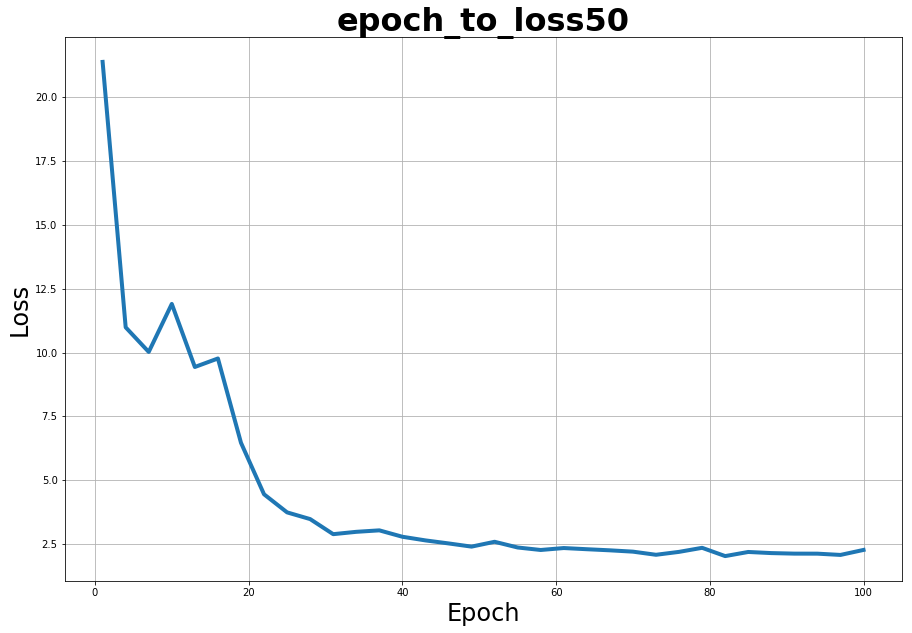

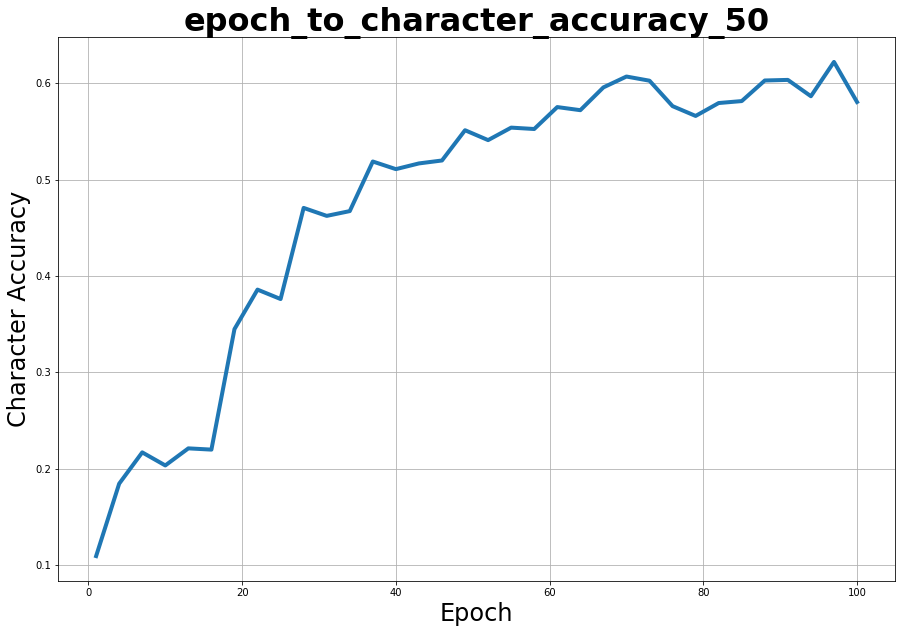

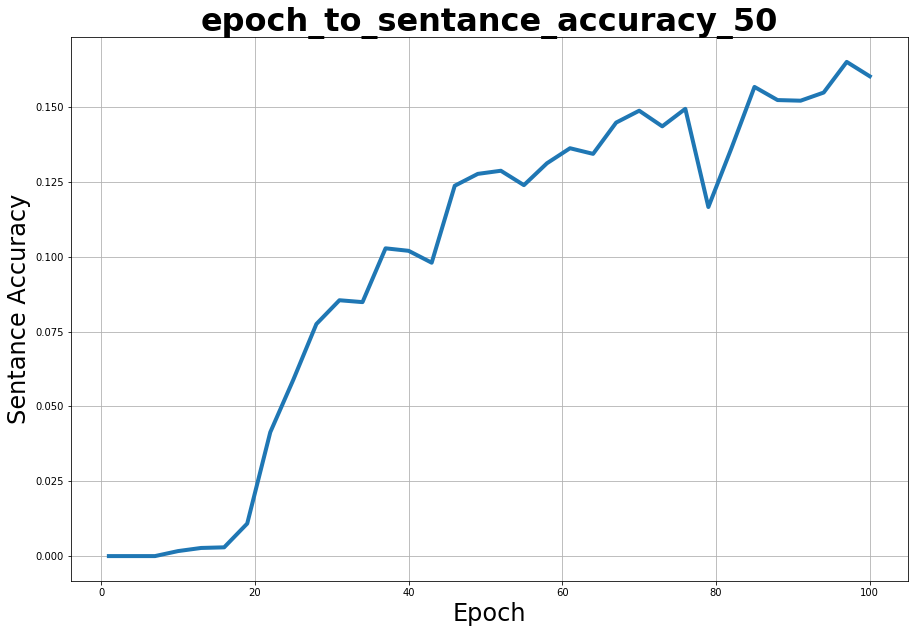

In [10]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="standard_dedup")

seq2seq, ave_loss, standard_character_accuracy_list, standard_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [11]:
torch.save(seq2seq.state_dict(), 'log/pth/standard_dedup_model_save.pth')

- Attention = Bahdanau
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

2019-02-27 02:56:52,754 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 02:58:11,369 INFO   Finished epoch 1: Train loss: 20.6615, Dev loss: 17.9721, Accuracy(Character): 0.1053, Accuracy(Word): 0.0000
2019-02-27 02:59:30,590 INFO   Finished epoch 2: Train loss: 15.9898, Dev loss: 19.3948, Accuracy(Character): 0.1073, Accuracy(Word): 0.0000
2019-02-27 03:00:43,653 INFO   Finished epoch 3: Train loss: 12.6411, Dev loss: 16.2733, Accuracy(Character): 0.1174, Accuracy(Word): 0.0000
2019-02-27 03:01:57,683 INFO   Finished epoch 4: Train loss: 10.8910, Dev loss: 14.6533, Accuracy(Character): 0.2021, Accuracy(Word): 0.0000
2019-02-27 03:03:12,183 INFO   Finished epoch 5: Train loss: 7.4532, Dev loss: 9.4248, Accuracy(Character): 0.2060, Accuracy(Word): 0.0000
2019-02-27 03:04:24,977 INFO   Finished epoch 6: Train loss: 6.1420, Dev loss: 8.8567, Accuracy(Character): 0.1940, Acc

2019-02-27 04:04:28,950 INFO   Finished epoch 59: Train loss: 2.1993, Dev loss: 2.6528, Accuracy(Character): 0.5700, Accuracy(Word): 0.1174
2019-02-27 04:05:33,387 INFO   Finished epoch 60: Train loss: 2.1169, Dev loss: 2.6584, Accuracy(Character): 0.5693, Accuracy(Word): 0.1074
2019-02-27 04:06:35,715 INFO   Finished epoch 61: Train loss: 2.1132, Dev loss: 2.6759, Accuracy(Character): 0.5646, Accuracy(Word): 0.1068
2019-02-27 04:07:42,022 INFO   Finished epoch 62: Train loss: 2.2063, Dev loss: 3.7075, Accuracy(Character): 0.4525, Accuracy(Word): 0.1287
2019-02-27 04:08:50,653 INFO   Finished epoch 63: Train loss: 2.0731, Dev loss: 2.5813, Accuracy(Character): 0.5795, Accuracy(Word): 0.1245
2019-02-27 04:09:54,841 INFO   Finished epoch 64: Train loss: 2.2019, Dev loss: 2.7892, Accuracy(Character): 0.5501, Accuracy(Word): 0.1053
2019-02-27 04:10:55,103 INFO   Finished epoch 65: Train loss: 1.9411, Dev loss: 2.6949, Accuracy(Character): 0.5616, Accuracy(Word): 0.0873
2019-02-27 04:11:55,

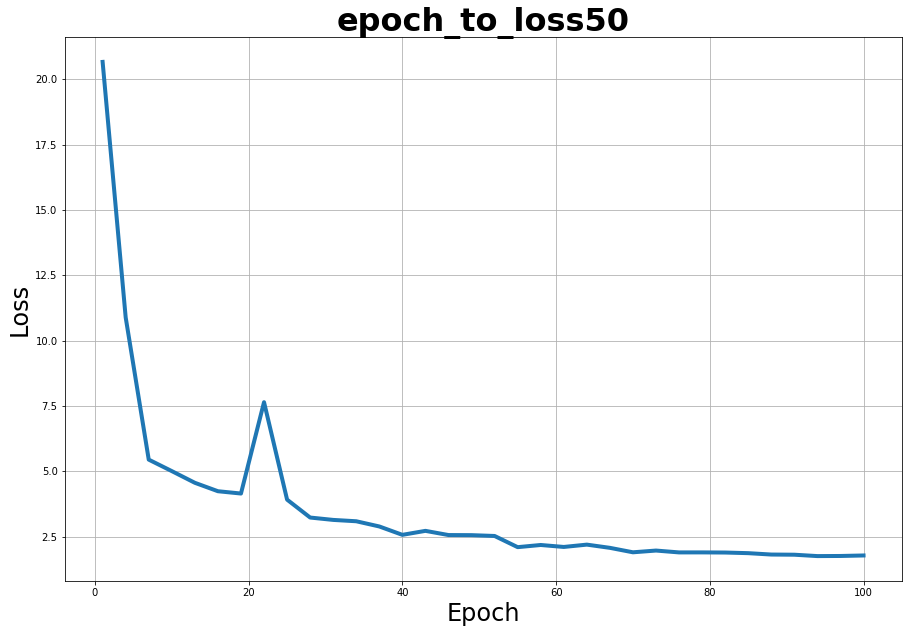

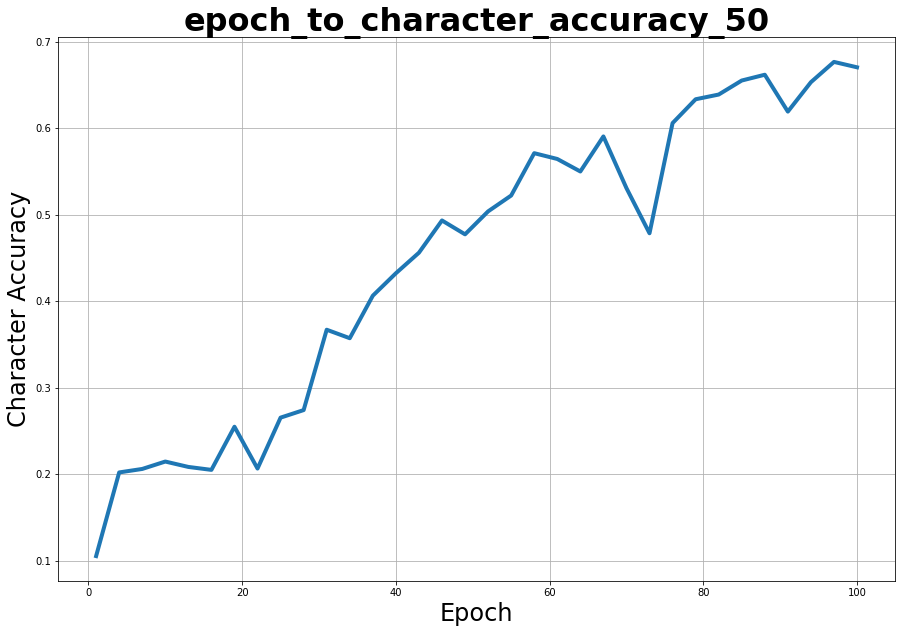

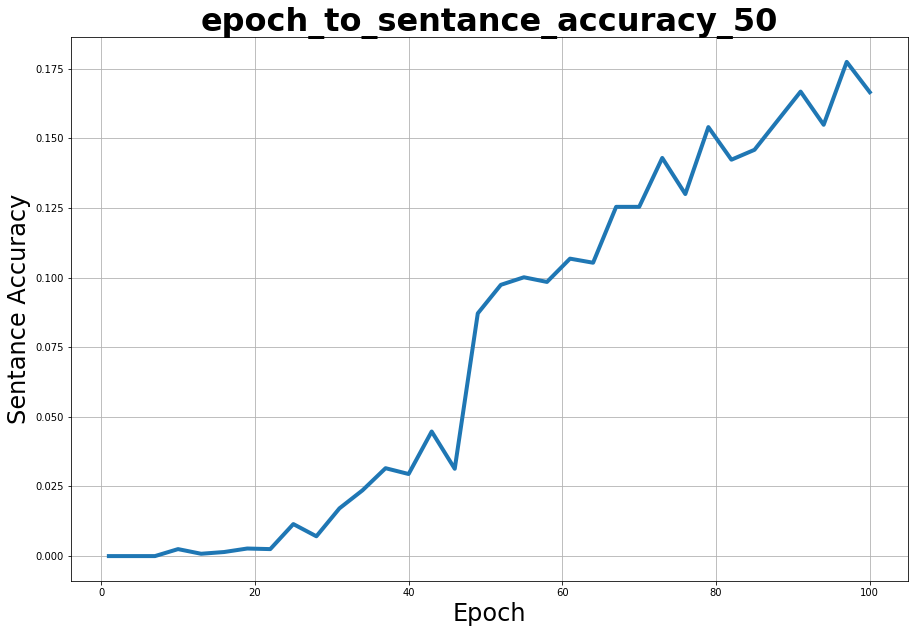

In [12]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Bahdanau", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Bahdanau_att_dedup")

seq2seq, ave_loss, bahdanau_att_character_accuracy_list, bahdanau_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [13]:
torch.save(seq2seq.state_dict(), 'log/pth/Bahdanau_att_dedup_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

2019-02-27 12:10:18,749 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-02-27 12:11:27,280 INFO   Finished epoch 1: Train loss: 20.5082, Dev loss: 16.7529, Accuracy(Character): 0.1093, Accuracy(Word): 0.0000
2019-02-27 12:12:31,521 INFO   Finished epoch 2: Train loss: 16.3572, Dev loss: 15.9063, Accuracy(Character): 0.1258, Accuracy(Word): 0.0000
2019-02-27 12:13:42,763 INFO   Finished epoch 3: Train loss: 15.2721, Dev loss: 16.9629, Accuracy(Character): 0.1234, Accuracy(Word): 0.0000
2019-02-27 12:15:02,913 INFO   Finished epoch 4: Train loss: 14.0172, Dev loss: 21.2595, Accuracy(Character): 0.1243, Accuracy(Word): 0.0000
2019-02-27 12:16:20,580 I

2019-02-27 13:34:10,333 INFO   Finished epoch 57: Train loss: 2.1270, Dev loss: 2.1884, Accuracy(Character): 0.6811, Accuracy(Word): 0.1989
2019-02-27 13:35:45,662 INFO   Finished epoch 58: Train loss: 2.0437, Dev loss: 2.2019, Accuracy(Character): 0.6839, Accuracy(Word): 0.2035
2019-02-27 13:37:19,492 INFO   Finished epoch 59: Train loss: 1.9234, Dev loss: 2.3720, Accuracy(Character): 0.6542, Accuracy(Word): 0.1858
2019-02-27 13:38:48,127 INFO   Finished epoch 60: Train loss: 1.9359, Dev loss: 2.2995, Accuracy(Character): 0.6545, Accuracy(Word): 0.2006
2019-02-27 13:40:23,258 INFO   Finished epoch 61: Train loss: 1.9587, Dev loss: 2.5374, Accuracy(Character): 0.6203, Accuracy(Word): 0.1768
2019-02-27 13:41:57,923 INFO   Finished epoch 62: Train loss: 1.8601, Dev loss: 2.9053, Accuracy(Character): 0.6279, Accuracy(Word): 0.2087
2019-02-27 13:43:30,912 INFO   Finished epoch 63: Train loss: 1.9315, Dev loss: 2.3084, Accuracy(Character): 0.6552, Accuracy(Word): 0.2020
2019-02-27 13:45:02,

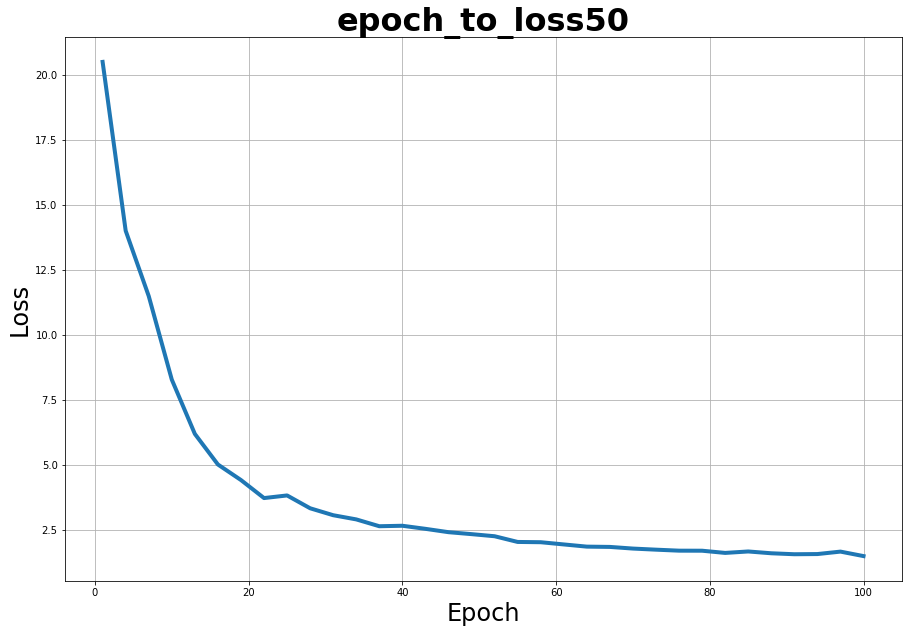

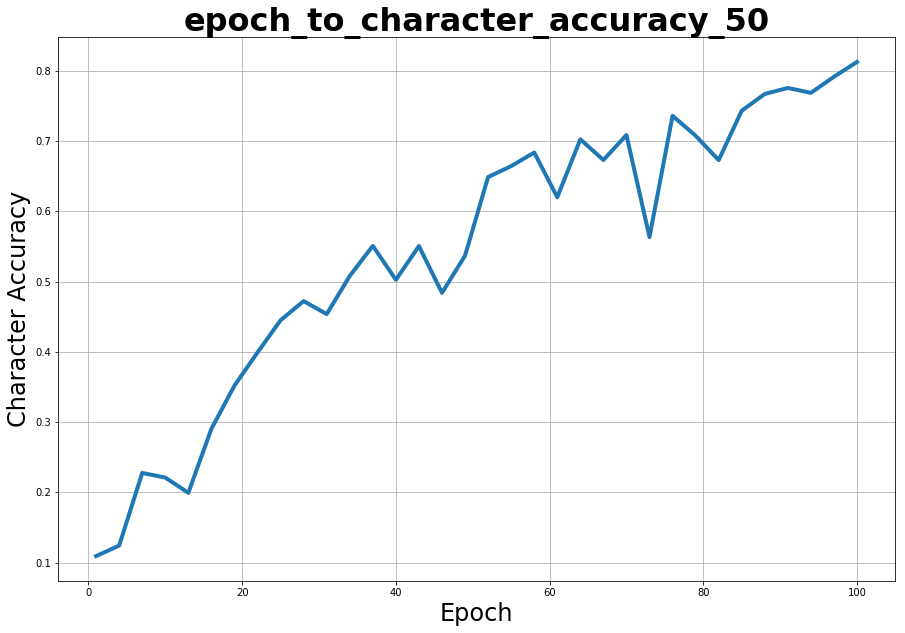

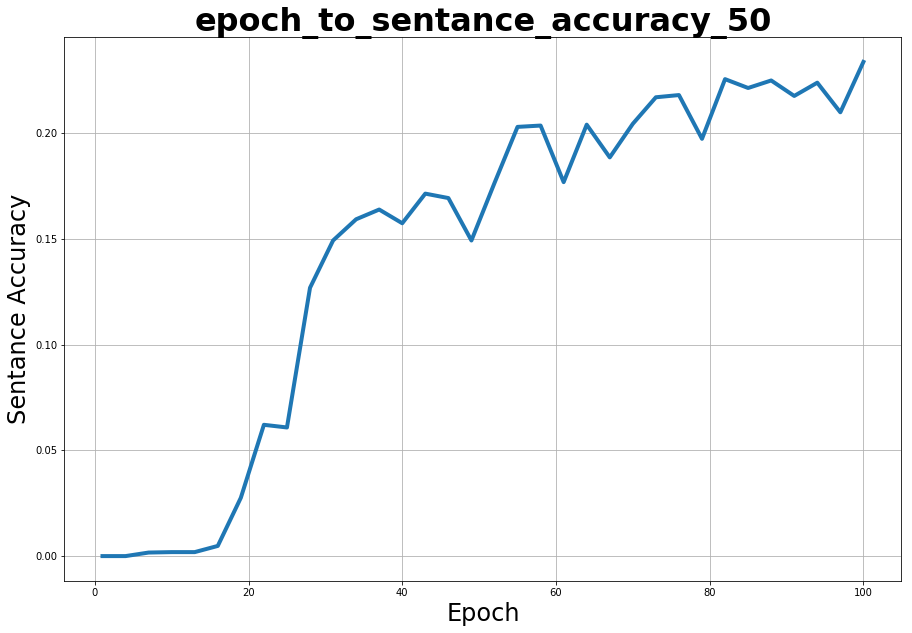

In [31]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Luong_att_dedup")

seq2seq, ave_loss, luong_att_character_accuracy_list, luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [32]:
torch.save(seq2seq.state_dict(), 'log/pth/Luong_att_dedup_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 1
- Layer = 1
- Batch size = 32

2019-02-27 06:09:59,578 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 06:10:43,693 INFO   Finished epoch 1: Train loss: 21.2046, Dev loss: 16.7112, Accuracy(Character): 0.1406, Accuracy(Word): 0.0000
2019-02-27 06:11:27,673 INFO   Finished epoch 2: Train loss: 11.0920, Dev loss: 64.0273, Accuracy(Character): 0.1263, Accuracy(Word): 0.0000
2019-02-27 06:12:09,591 INFO   Finished epoch 3: Train loss: 6.5868, Dev loss: 134.7281, Accuracy(Character): 0.1201, Accuracy(Word): 0.0000
2019-02-27 06:12:48,333 INFO   Finished epoch 4: Train loss: 3.5504, Dev loss: 83.3743, Accuracy(Character): 0.1885, Accuracy(Word): 0.0017
2019-02-27 06:13:28,907 INFO   Finished epoch 5: Train loss: 2.2089, Dev loss: 1063.4329, Accuracy(Character): 0.1331, Accuracy(Word): 0.0017
2019-02-27 06:14:09,131 INFO   Finished epoch 6: Train loss: 1.9832, Dev loss: 4308.1727, Accuracy(Character): 0.1051

2019-02-27 06:49:55,032 INFO   Finished epoch 58: Train loss: 1.4743, Dev loss: 20.6471, Accuracy(Character): 0.5152, Accuracy(Word): 0.1394
2019-02-27 06:50:36,106 INFO   Finished epoch 59: Train loss: 1.4745, Dev loss: 50.0285, Accuracy(Character): 0.4923, Accuracy(Word): 0.1429
2019-02-27 06:51:17,128 INFO   Finished epoch 60: Train loss: 1.4708, Dev loss: 39.6169, Accuracy(Character): 0.4937, Accuracy(Word): 0.1463
2019-02-27 06:51:55,318 INFO   Finished epoch 61: Train loss: 1.4672, Dev loss: 24.3290, Accuracy(Character): 0.4985, Accuracy(Word): 0.0867
2019-02-27 06:52:35,196 INFO   Finished epoch 62: Train loss: 1.4682, Dev loss: 26.7342, Accuracy(Character): 0.5021, Accuracy(Word): 0.1425
2019-02-27 06:53:18,510 INFO   Finished epoch 63: Train loss: 1.4689, Dev loss: 26.8745, Accuracy(Character): 0.5063, Accuracy(Word): 0.1448
2019-02-27 06:54:01,364 INFO   Finished epoch 64: Train loss: 1.4684, Dev loss: 86.5475, Accuracy(Character): 0.4581, Accuracy(Word): 0.0846
2019-02-27 06

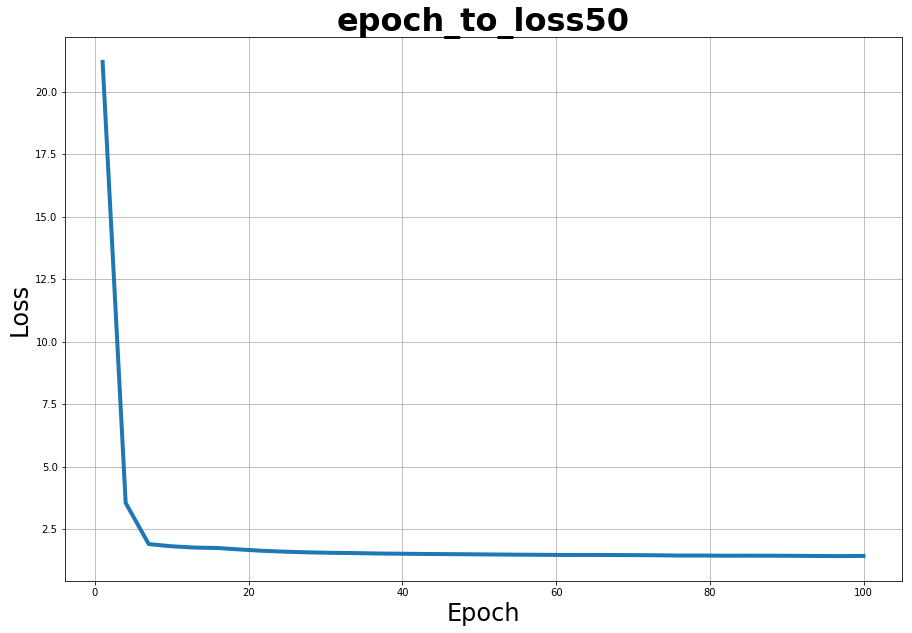

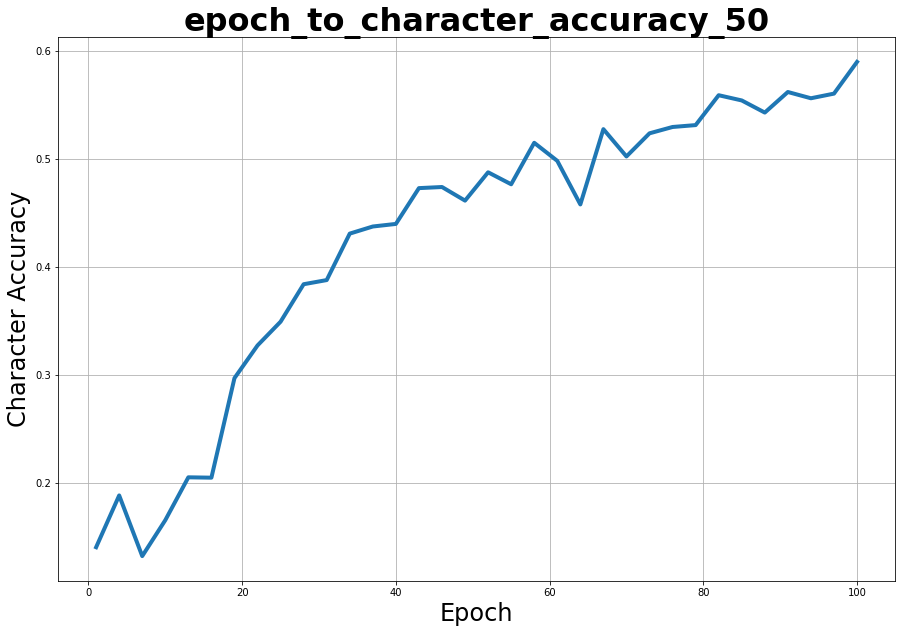

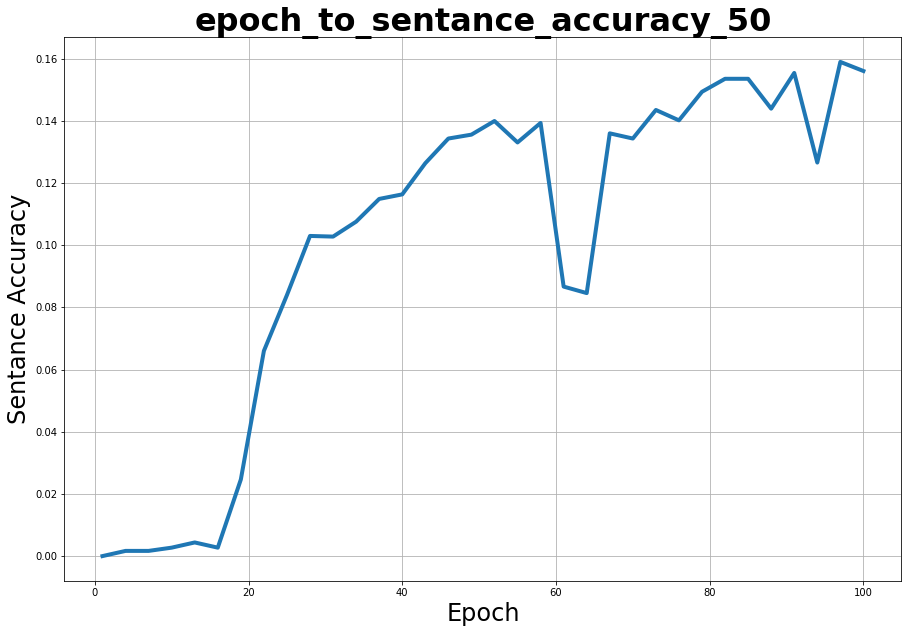

In [ ]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Teacher_Forcing_Ratio_1_dedup")

seq2seq, ave_loss, tfr_character_accuracy_list, tfr_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=1)

In [ ]:
torch.save(seq2seq.state_dict(), 'log/pth/Teacher_Forcing_Ratio_1_dedup_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 64

2019-02-27 07:14:38,463 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 07:14:58,332 INFO   Finished epoch 1: Train loss: 25.6662, Dev loss: 17.7894, Accuracy(Character): 0.0902, Accuracy(Word): 0.0000
2019-02-27 07:15:17,496 INFO   Finished epoch 2: Train loss: 17.2596, Dev loss: 16.6477, Accuracy(Character): 0.1209, Accuracy(Word): 0.0000
2019-02-27 07:15:36,230 INFO   Finished epoch 3: Train loss: 16.5920, Dev loss: 16.2827, Accuracy(Character): 0.1044, Accuracy(Word): 0.0000
2019-02-27 07:15:55,814 INFO   Finished epoch 4: Train loss: 15.5134, Dev loss: 15.8773, Accuracy(Character): 0.1932, Accuracy(Word): 0.0000
2019-02-27 07:16:14,585 INFO   Finished epoch 5: Train loss: 11.1475, Dev loss: 10.7106, Accuracy(Character): 0.1839, Accuracy(Word): 0.0000
2019-02-27 07:16:34,444 INFO   Finished epoch 6: Train loss: 8.7500, Dev loss: 10.5170, Accuracy(Character): 0.1924, 

2019-02-27 07:33:39,923 INFO   Finished epoch 59: Train loss: 2.9345, Dev loss: 3.5196, Accuracy(Character): 0.4979, Accuracy(Word): 0.1064
2019-02-27 07:33:58,891 INFO   Finished epoch 60: Train loss: 2.7927, Dev loss: 3.6638, Accuracy(Character): 0.4932, Accuracy(Word): 0.1107
2019-02-27 07:34:13,782 INFO   Finished epoch 61: Train loss: 2.6665, Dev loss: 3.9749, Accuracy(Character): 0.4871, Accuracy(Word): 0.1206
2019-02-27 07:34:29,248 INFO   Finished epoch 62: Train loss: 2.5072, Dev loss: 3.3261, Accuracy(Character): 0.5262, Accuracy(Word): 0.1168
2019-02-27 07:34:44,211 INFO   Finished epoch 63: Train loss: 2.7191, Dev loss: 3.2405, Accuracy(Character): 0.5381, Accuracy(Word): 0.1212
2019-02-27 07:34:59,700 INFO   Finished epoch 64: Train loss: 2.6509, Dev loss: 4.7645, Accuracy(Character): 0.4889, Accuracy(Word): 0.1137
2019-02-27 07:35:14,544 INFO   Finished epoch 65: Train loss: 2.4825, Dev loss: 4.0001, Accuracy(Character): 0.4750, Accuracy(Word): 0.1176
2019-02-27 07:35:29,

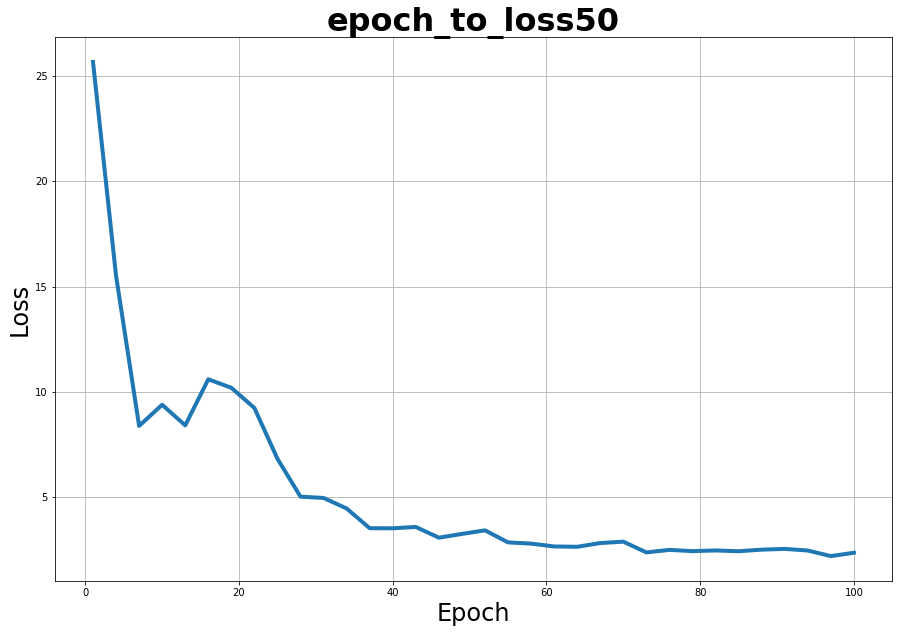

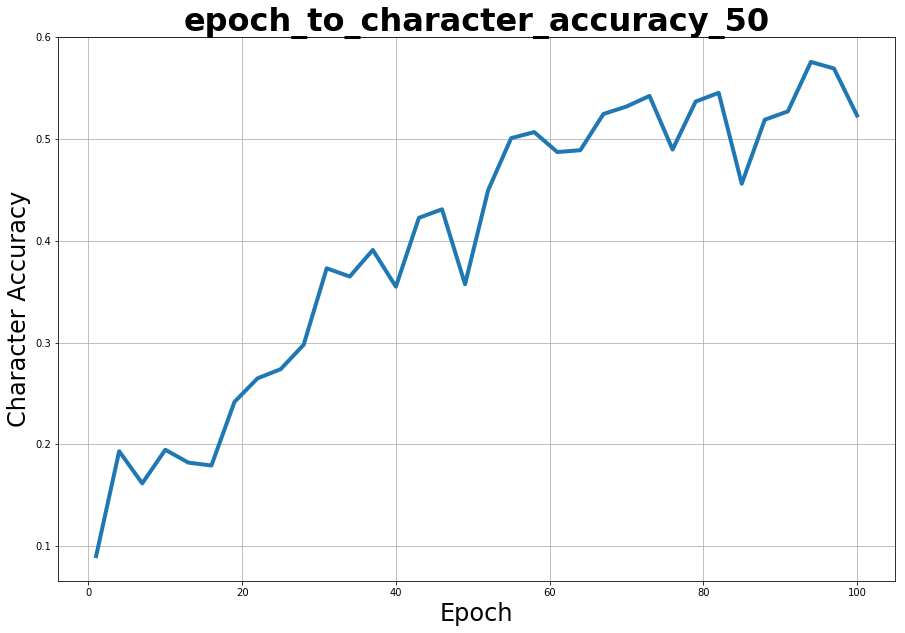

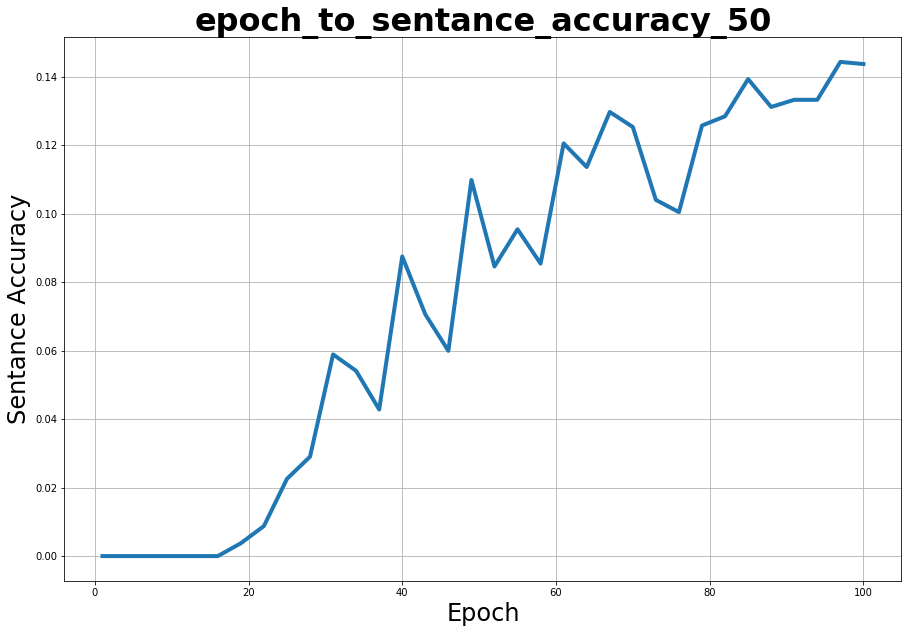

In [ ]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=64,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="batch_size_64_dedup")

seq2seq, ave_loss, batch_size_64_character_accuracy_list, batch_size_64_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [ ]:
torch.save(seq2seq.state_dict(), 'log/pth/batch_size_64_dedup_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 2
- Batch size = 32

In [ ]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=2,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, n_layers=2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="two_layer_dedup")

seq2seq, ave_loss, two_layer_character_accuracy_list, two_layer_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

2019-02-27 07:44:08,099 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 07:44:43,209 INFO   Finished epoch 1: Train loss: 20.5947, Dev loss: 16.6907, Accuracy(Character): 0.1136, Accuracy(Word): 0.0000
2019-02-27 07:45:17,219 INFO   Finished epoch 2: Train loss: 16.3698, Dev loss: 16.2097, Accuracy(Character): 0.1336, Accuracy(Word): 0.0000
2019-02-27 07:45:51,442 INFO   Finished epoch 3: Train loss: 11.0782, Dev loss: 8.9506, Accuracy(Character): 0.2216, Accuracy(Word): 0.0000
2019-02-27 07:46:25,774 INFO   Finished epoch 4: Train loss: 7.6605, Dev loss: 7.6693, Accuracy(Character): 0.2400, Accuracy(Word): 0.0000
2019-02-27 07:47:00,742 INFO   Finished epoch 5: Train loss: 7.6640, Dev loss: 8.2913, Accuracy(Character): 0.2331, Accuracy(Word): 0.0025
2019-02-27 07:47:35,057 INFO   Finished epoch 6: Train loss: 7.1858, Dev loss: 41.5419, Accuracy(Character): 0.1867, Accur

In [25]:
torch.save(seq2seq.state_dict(), 'log/pth/two_layer_dedup_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Pretrained

2019-02-27 09:51:23,505 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


pretrain..


2019-02-27 09:51:37,443 INFO   Finished epoch 1: Train loss: 15.0344, Dev loss: 12.1410, Accuracy(Character): 0.1503, Accuracy(Word): 0.0000
2019-02-27 09:51:51,426 INFO   Finished epoch 2: Train loss: 9.9246, Dev loss: 11.3632, Accuracy(Character): 0.1918, Accuracy(Word): 0.0000
2019-02-27 09:52:04,888 INFO   Finished epoch 3: Train loss: 7.9724, Dev loss: 8.7335, Accuracy(Character): 0.2759, Accuracy(Word): 0.0000
2019-02-27 09:52:18,376 INFO   Finished epoch 4: Train loss: 4.0274, Dev loss: 5.0327, Accuracy(Character): 0.3734, Accuracy(Word): 0.0016
2019-02-27 09:52:32,731 INFO   Finished epoch 5: Train loss: 3.2469, Dev loss: 5.2312, Accuracy(Character): 0.3926, Accuracy(Word): 0.0015
2019-02-27 09:52:46,504 INFO   Finished epoch 6: Train loss: 3.1016, Dev loss: 4.8016, Accuracy(Character): 0.4262, Accuracy(Word): 0.0029
2019-02-27 09:53:00,890 INFO   Finished epoch 7: Train loss: 3.1597, Dev loss: 8.8095, Accuracy(Character): 0.3618, Accuracy(Word): 0.0035
2019-02-27 09:53:14,573 

train..


2019-02-27 10:03:16,516 INFO   Finished epoch 1: Train loss: 1625.2568, Dev loss: 20.9616, Accuracy(Character): 0.1690, Accuracy(Word): 0.0000
2019-02-27 10:03:41,184 INFO   Finished epoch 2: Train loss: 11.7383, Dev loss: 23.1096, Accuracy(Character): 0.1836, Accuracy(Word): 0.0006
2019-02-27 10:04:05,137 INFO   Finished epoch 3: Train loss: 11.2874, Dev loss: 14.6981, Accuracy(Character): 0.1995, Accuracy(Word): 0.0046
2019-02-27 10:04:29,438 INFO   Finished epoch 4: Train loss: 10.7449, Dev loss: 16.4151, Accuracy(Character): 0.1923, Accuracy(Word): 0.0029
2019-02-27 10:04:54,078 INFO   Finished epoch 5: Train loss: 9.5164, Dev loss: 10.5988, Accuracy(Character): 0.2120, Accuracy(Word): 0.0056
2019-02-27 10:05:18,528 INFO   Finished epoch 6: Train loss: 8.8056, Dev loss: 10.2706, Accuracy(Character): 0.2003, Accuracy(Word): 0.0048
2019-02-27 10:05:42,140 INFO   Finished epoch 7: Train loss: 8.8591, Dev loss: 12.2527, Accuracy(Character): 0.2212, Accuracy(Word): 0.0073
2019-02-27 10:

2019-02-27 10:32:48,359 INFO   Finished epoch 60: Train loss: 2.5964, Dev loss: 4.1115, Accuracy(Character): 0.4825, Accuracy(Word): 0.1041
2019-02-27 10:33:18,614 INFO   Finished epoch 61: Train loss: 2.6991, Dev loss: 3.4431, Accuracy(Character): 0.4673, Accuracy(Word): 0.0932
2019-02-27 10:33:48,225 INFO   Finished epoch 62: Train loss: 2.5901, Dev loss: 4.5811, Accuracy(Character): 0.4614, Accuracy(Word): 0.0704
2019-02-27 10:34:18,611 INFO   Finished epoch 63: Train loss: 3.0210, Dev loss: 5.2755, Accuracy(Character): 0.4304, Accuracy(Word): 0.0949
2019-02-27 10:34:49,406 INFO   Finished epoch 64: Train loss: 2.6341, Dev loss: 3.6077, Accuracy(Character): 0.4880, Accuracy(Word): 0.1038
2019-02-27 10:35:22,153 INFO   Finished epoch 65: Train loss: 2.7443, Dev loss: 3.7540, Accuracy(Character): 0.5011, Accuracy(Word): 0.1089
2019-02-27 10:35:54,262 INFO   Finished epoch 66: Train loss: 2.9204, Dev loss: 9.3762, Accuracy(Character): 0.4104, Accuracy(Word): 0.1066
2019-02-27 10:36:25,

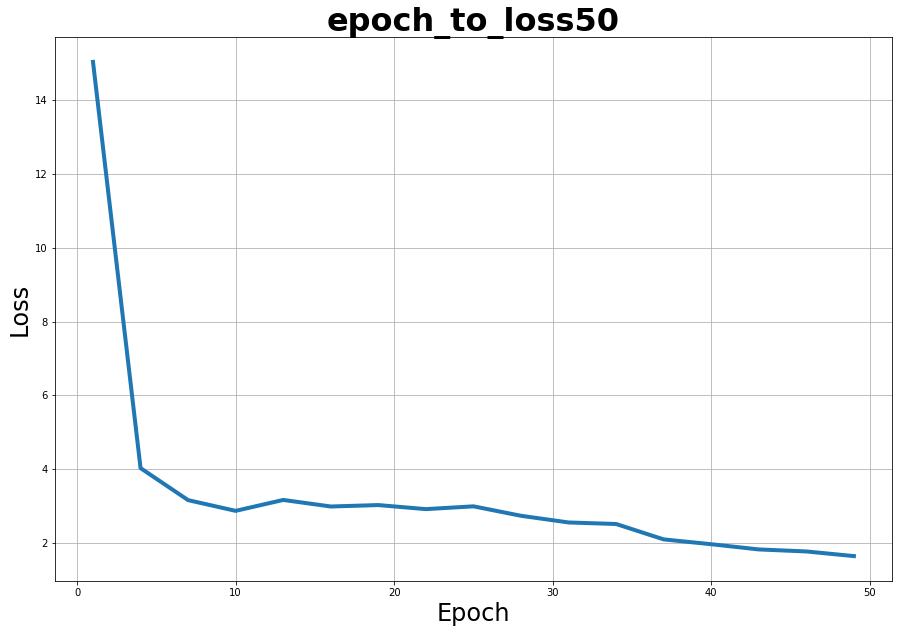

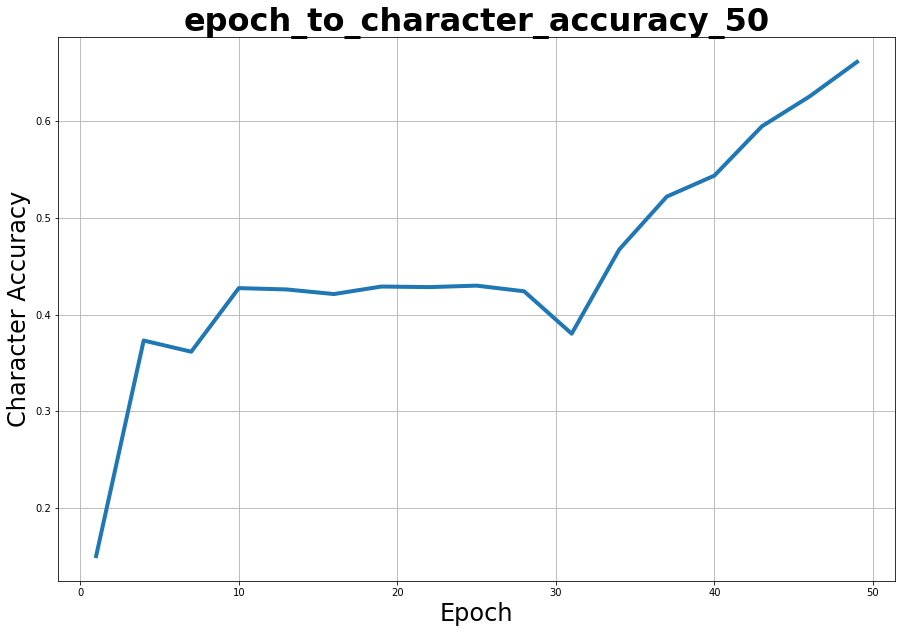

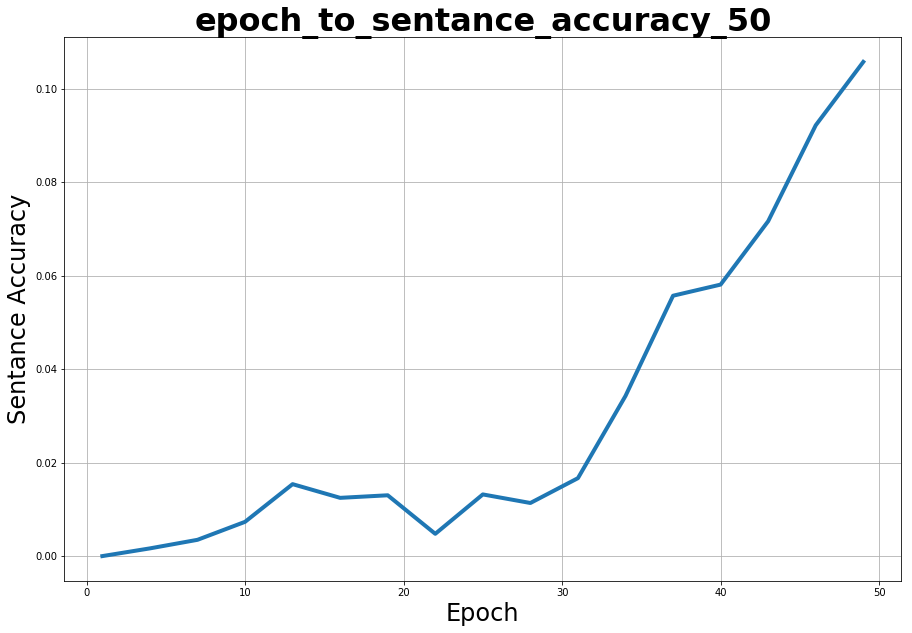

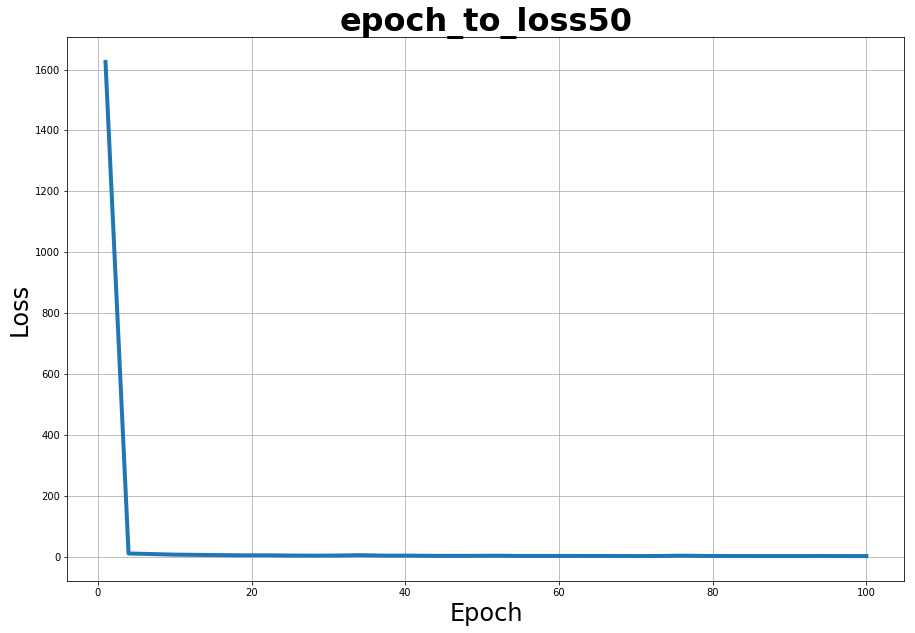

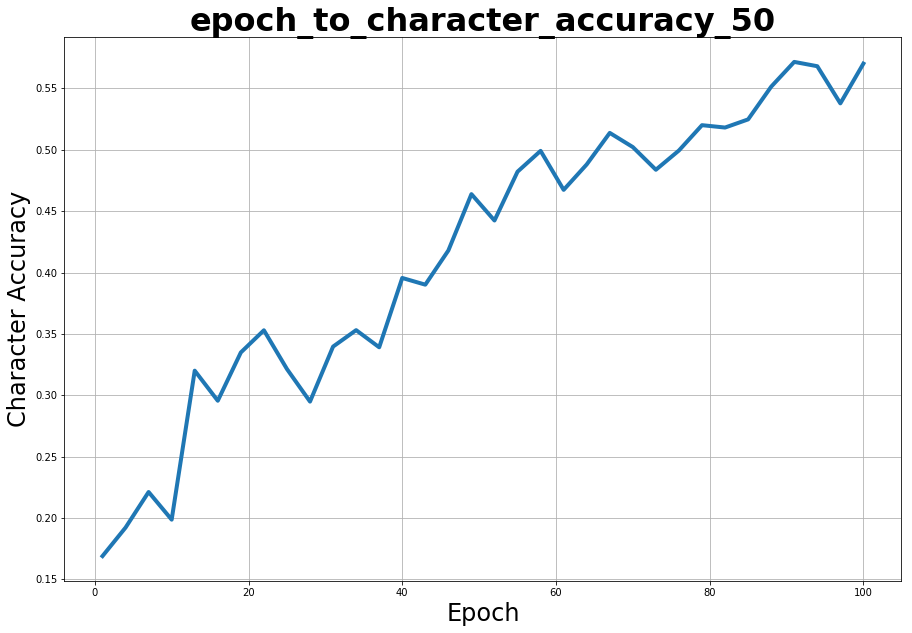

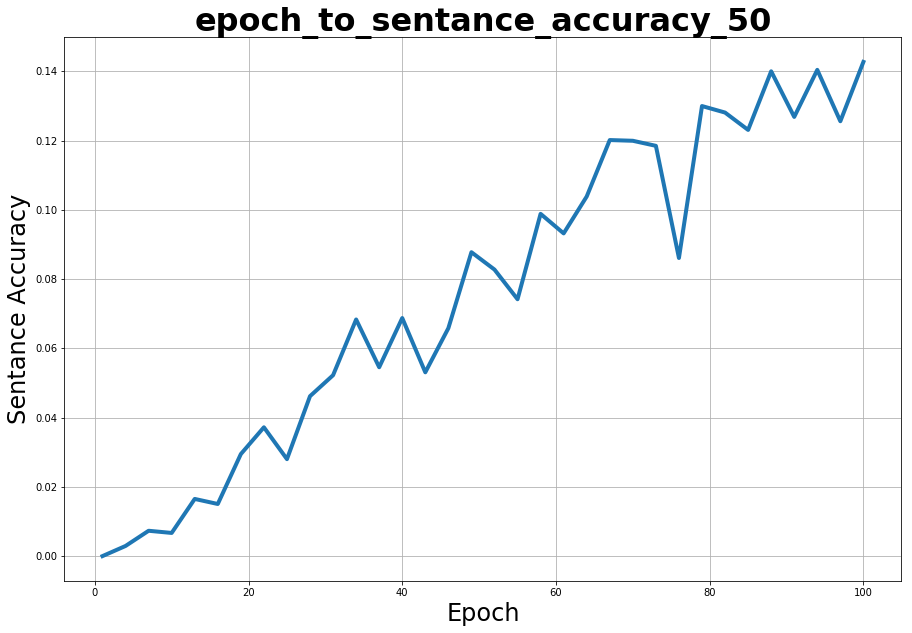

In [26]:
encoder = EncoderRNN(len(pretrain_src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(pretrain_tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                    eos_id=pretrain_tgt.eos_id, sos_id=pretrain_tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=pretrain_loss, batch_size=32,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=hidden_size,
                    path="pretrained_dedup")
print("pretrain..")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, pretrain_train,
                  num_epochs=50, dev_data=pretrain_dev,
                  optimizer=optimizer,
                  teacher_forcing_ratio=0.5)
    
print("train..")
seq2seq, ave_loss, pretrained_character_accuracy_list, pretrained_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [27]:
torch.save(seq2seq.state_dict(), 'log/pth/pretrained_dedup_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 2
- Batch size = 32

2019-02-27 14:39:36,721 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 14:41:15,747 INFO   Finished epoch 1: Train loss: 20.2112, Dev loss: 16.7802, Accuracy(Character): 0.1135, Accuracy(Word): 0.0000
2019-02-27 14:42:47,278 INFO   Finished epoch 2: Train loss: 16.2579, Dev loss: 15.9775, Accuracy(Character): 0.1221, Accuracy(Word): 0.0000
2019-02-27 14:44:12,407 INFO   Finished epoch 3: Train loss: 15.5316, Dev loss: 16.2477, Accuracy(Character): 0.1349, Accuracy(Word): 0.0017
2019-02-27 14:45:45,870 INFO   Finished epoch 4: Train loss: 12.2285, Dev loss: 19.1647, Accuracy(Character): 0.1753, Accuracy(Word): 0.0036
2019-02-27 14:47:20,500 INFO   Finished epoch 5: Train loss: 7.6314, Dev loss: 5.9366, Accuracy(Character): 0.3162, Accuracy(Word): 0.0042
2019-02-27 14:48:45,660 INFO   Finished epoch 6: Train loss: 4.9196, Dev loss: 6.3354, Accuracy(Character): 0.3309, Acc

2019-02-27 16:15:23,643 INFO   Finished epoch 59: Train loss: 1.6037, Dev loss: 1.6980, Accuracy(Character): 0.7696, Accuracy(Word): 0.2041
2019-02-27 16:17:05,372 INFO   Finished epoch 60: Train loss: 1.5261, Dev loss: 2.5573, Accuracy(Character): 0.7113, Accuracy(Word): 0.2035
2019-02-27 16:18:42,240 INFO   Finished epoch 61: Train loss: 1.5677, Dev loss: 1.7142, Accuracy(Character): 0.7755, Accuracy(Word): 0.2046
2019-02-27 16:20:25,496 INFO   Finished epoch 62: Train loss: 1.5702, Dev loss: 1.8023, Accuracy(Character): 0.7491, Accuracy(Word): 0.2008
2019-02-27 16:22:03,390 INFO   Finished epoch 63: Train loss: 1.5223, Dev loss: 1.6986, Accuracy(Character): 0.7742, Accuracy(Word): 0.2000
2019-02-27 16:23:53,093 INFO   Finished epoch 64: Train loss: 1.5800, Dev loss: 1.6925, Accuracy(Character): 0.7828, Accuracy(Word): 0.1958
2019-02-27 16:25:31,510 INFO   Finished epoch 65: Train loss: 1.4931, Dev loss: 2.2622, Accuracy(Character): 0.7111, Accuracy(Word): 0.2000
2019-02-27 16:27:11,

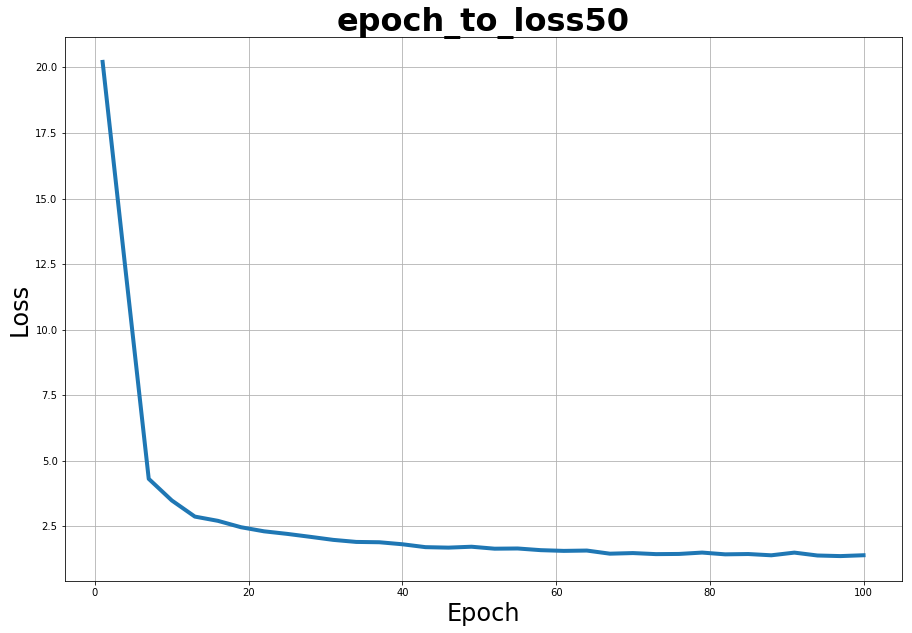

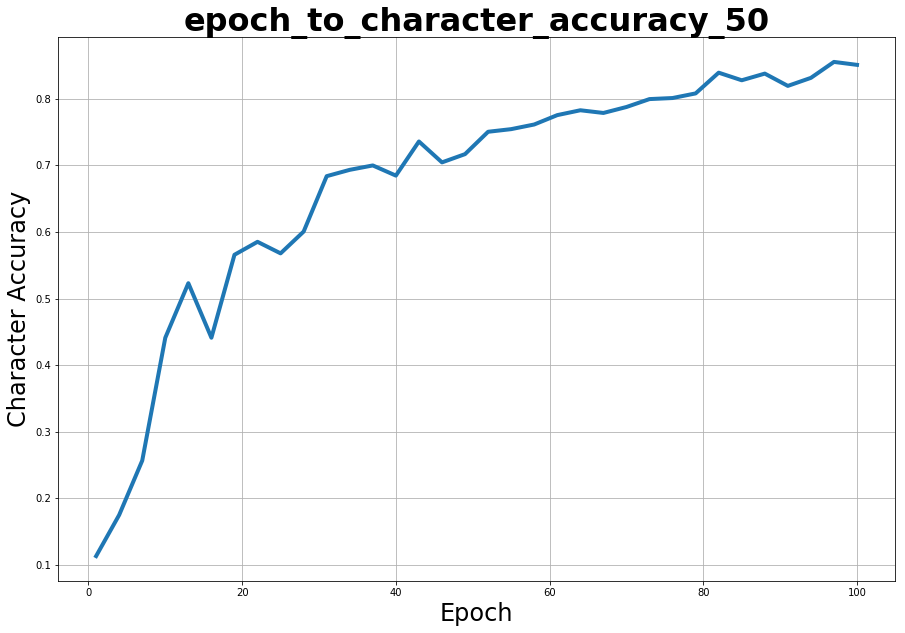

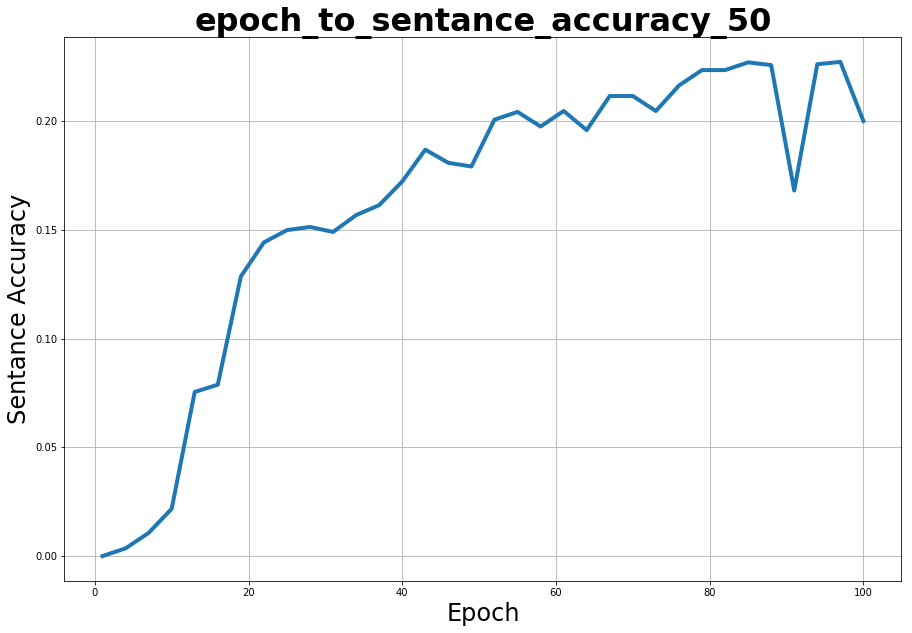

In [33]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=2,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, n_layers=2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="two_layer_Luong_att_rand_dedup")

seq2seq, ave_loss, two_layer_Luong_att_character_accuracy_list, two_layer_Luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                                                            num_epochs=100, dev_data=dev,
                                                                                                            optimizer=optimizer,
                                                                                                            teacher_forcing_ratio=0.5)

In [34]:
torch.save(seq2seq.state_dict(), 'log/pth/two_layer_Luong_att_dedup_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Pretrained

2019-02-27 17:25:45,690 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


pretrain..


2019-02-27 17:26:36,836 INFO   Finished epoch 1: Train loss: 14.2270, Dev loss: 11.9307, Accuracy(Character): 0.1556, Accuracy(Word): 0.0000
2019-02-27 17:27:31,448 INFO   Finished epoch 2: Train loss: 10.0007, Dev loss: 11.6368, Accuracy(Character): 0.1695, Accuracy(Word): 0.0000
2019-02-27 17:28:21,878 INFO   Finished epoch 3: Train loss: 9.4798, Dev loss: 11.2901, Accuracy(Character): 0.1657, Accuracy(Word): 0.0000
2019-02-27 17:29:18,187 INFO   Finished epoch 4: Train loss: 8.2152, Dev loss: 9.8279, Accuracy(Character): 0.2191, Accuracy(Word): 0.0000
2019-02-27 17:30:10,815 INFO   Finished epoch 5: Train loss: 5.7540, Dev loss: 8.6171, Accuracy(Character): 0.3369, Accuracy(Word): 0.0027
2019-02-27 17:31:04,424 INFO   Finished epoch 6: Train loss: 3.6472, Dev loss: 6.3668, Accuracy(Character): 0.3916, Accuracy(Word): 0.0020
2019-02-27 17:31:58,479 INFO   Finished epoch 7: Train loss: 3.0563, Dev loss: 5.0051, Accuracy(Character): 0.4280, Accuracy(Word): 0.0020
2019-02-27 17:32:53,50

train..


2019-02-27 18:11:48,885 INFO   Finished epoch 1: Train loss: 777560.6161, Dev loss: 7.7494, Accuracy(Character): 0.2792, Accuracy(Word): 0.0000
2019-02-27 18:13:15,776 INFO   Finished epoch 2: Train loss: 6.1354, Dev loss: 6.2813, Accuracy(Character): 0.3243, Accuracy(Word): 0.0010
2019-02-27 18:14:46,474 INFO   Finished epoch 3: Train loss: 5.2630, Dev loss: 6.9495, Accuracy(Character): 0.3009, Accuracy(Word): 0.0023
2019-02-27 18:16:19,860 INFO   Finished epoch 4: Train loss: 5.4087, Dev loss: 5.8130, Accuracy(Character): 0.3347, Accuracy(Word): 0.0036
2019-02-27 18:17:48,209 INFO   Finished epoch 5: Train loss: 6.0982, Dev loss: 8.0563, Accuracy(Character): 0.3123, Accuracy(Word): 0.0052
2019-02-27 18:19:17,794 INFO   Finished epoch 6: Train loss: 5.1349, Dev loss: 6.8460, Accuracy(Character): 0.3233, Accuracy(Word): 0.0048
2019-02-27 18:20:44,887 INFO   Finished epoch 7: Train loss: 4.9879, Dev loss: 7.5613, Accuracy(Character): 0.3384, Accuracy(Word): 0.0052
2019-02-27 18:22:15,25

2019-02-27 19:40:08,939 INFO   Finished epoch 60: Train loss: 1.3319, Dev loss: 1.3843, Accuracy(Character): 0.8807, Accuracy(Word): 0.2796
2019-02-27 19:41:35,729 INFO   Finished epoch 61: Train loss: 1.2696, Dev loss: 1.4951, Accuracy(Character): 0.8593, Accuracy(Word): 0.2883
2019-02-27 19:43:03,206 INFO   Finished epoch 62: Train loss: 1.3305, Dev loss: 1.2585, Accuracy(Character): 0.9060, Accuracy(Word): 0.3542
2019-02-27 19:44:30,302 INFO   Finished epoch 63: Train loss: 1.2508, Dev loss: 1.3850, Accuracy(Character): 0.8631, Accuracy(Word): 0.3032
2019-02-27 19:45:57,089 INFO   Finished epoch 64: Train loss: 1.2509, Dev loss: 1.5051, Accuracy(Character): 0.8415, Accuracy(Word): 0.2710
2019-02-27 19:47:28,821 INFO   Finished epoch 65: Train loss: 1.2976, Dev loss: 1.5194, Accuracy(Character): 0.8621, Accuracy(Word): 0.2850
2019-02-27 19:48:53,410 INFO   Finished epoch 66: Train loss: 1.2458, Dev loss: 1.2410, Accuracy(Character): 0.9113, Accuracy(Word): 0.3464
2019-02-27 19:50:21,

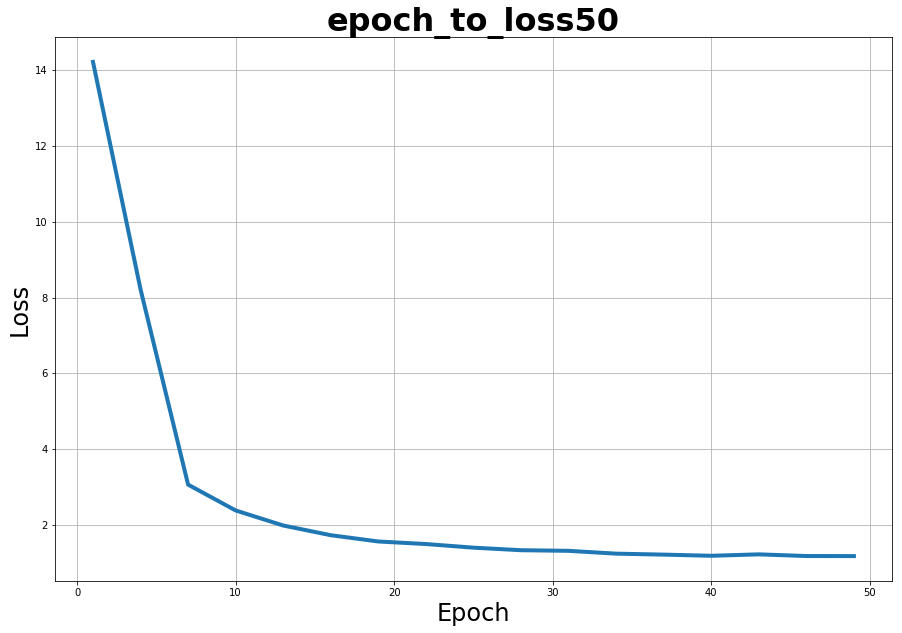

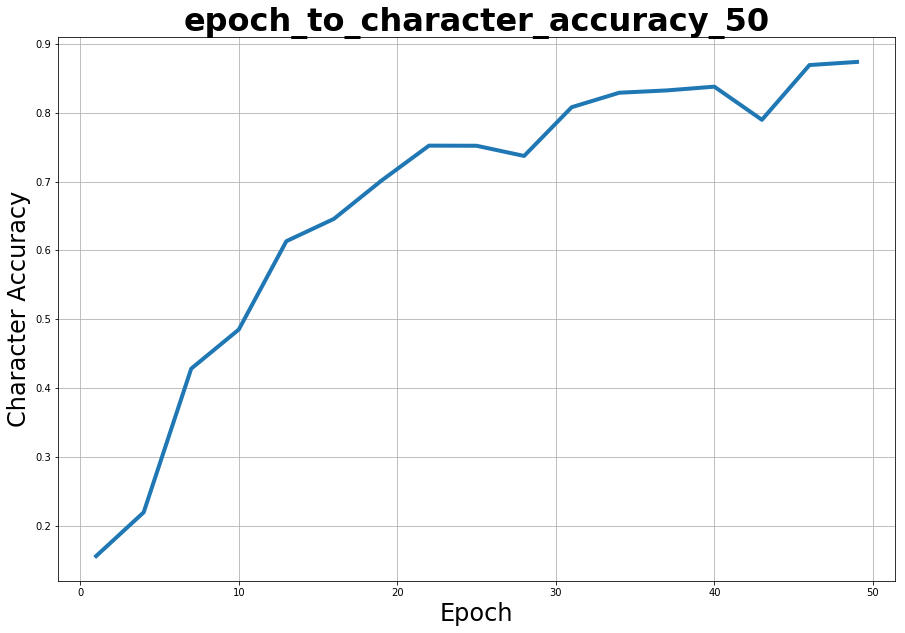

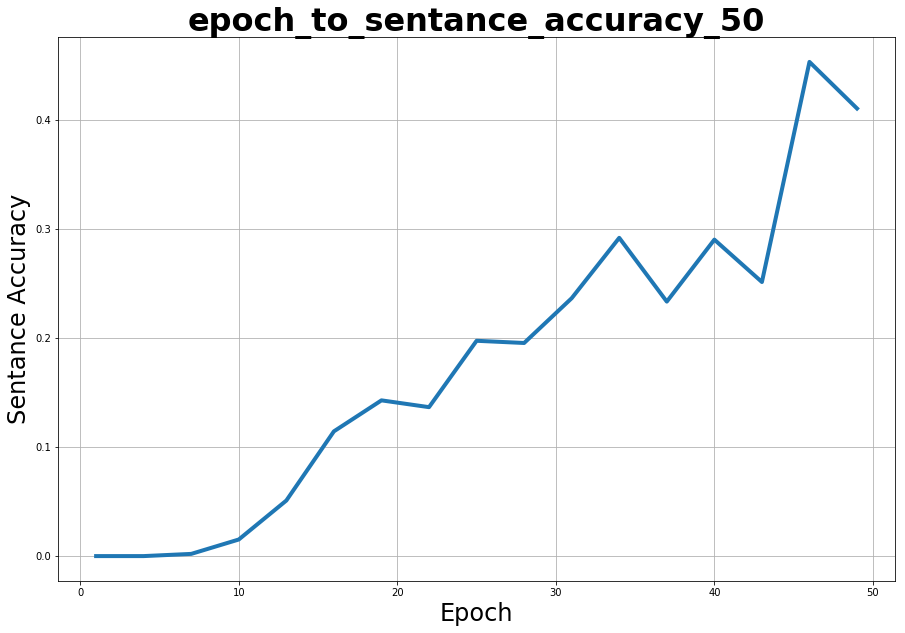

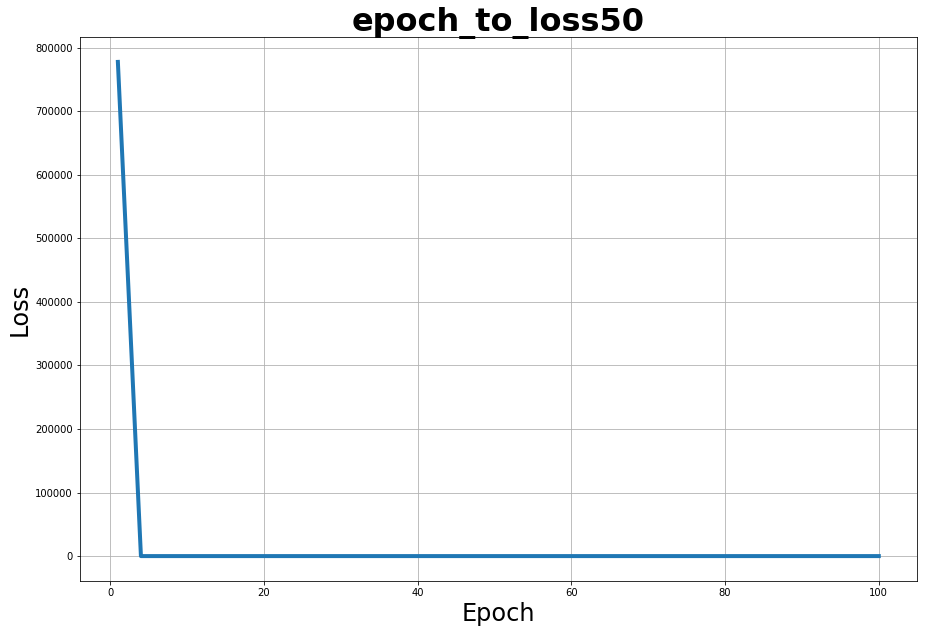

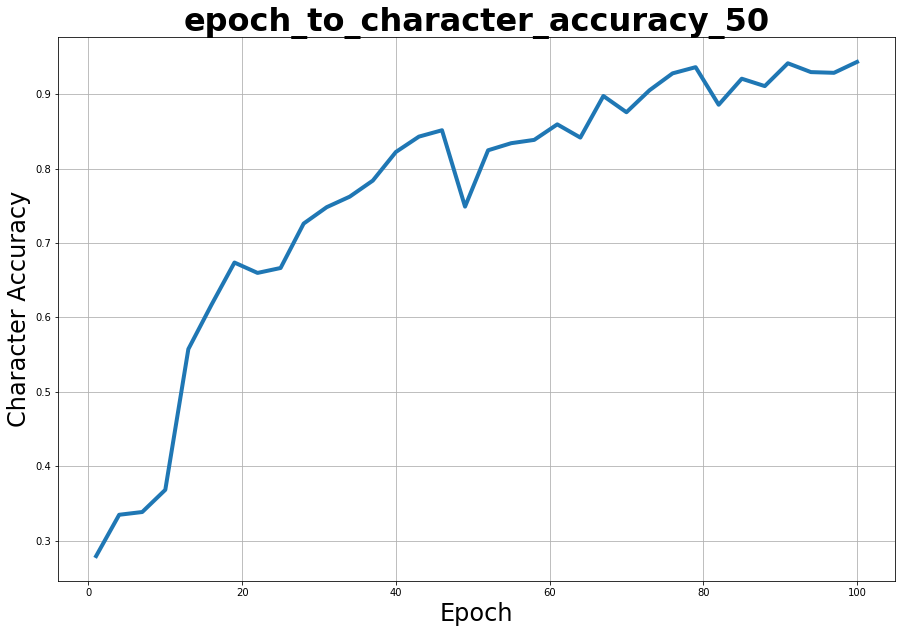

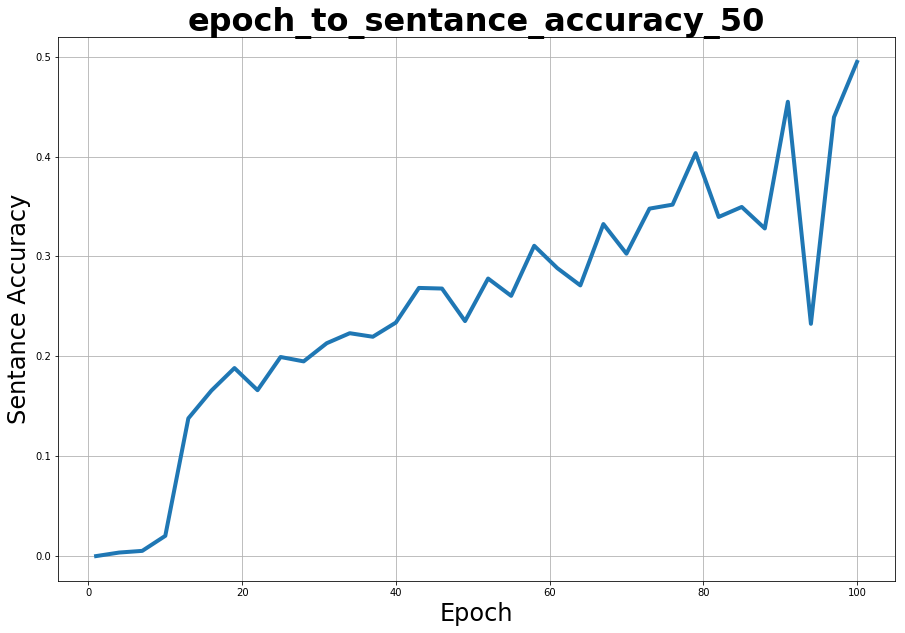

In [35]:
encoder = EncoderRNN(len(pretrain_src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(pretrain_tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                    eos_id=pretrain_tgt.eos_id, sos_id=pretrain_tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=pretrain_loss, batch_size=32,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=hidden_size,
                    path="pretrained_Luong_att")
print("pretrain..")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, pretrain_train,
                  num_epochs=50, dev_data=pretrain_dev,
                  optimizer=optimizer,
                  teacher_forcing_ratio=0.5)
    
print("train..")
seq2seq, ave_loss, pretrained_Luong_att_character_accuracy_list, pretrained_Luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                                                                    num_epochs=100, dev_data=dev,
                                                                                                                    optimizer=optimizer,
                                                                                                                    teacher_forcing_ratio=0.5)

In [36]:
torch.save(seq2seq.state_dict(), 'log/pth/pretrained_Luong_att_model_save.pth')

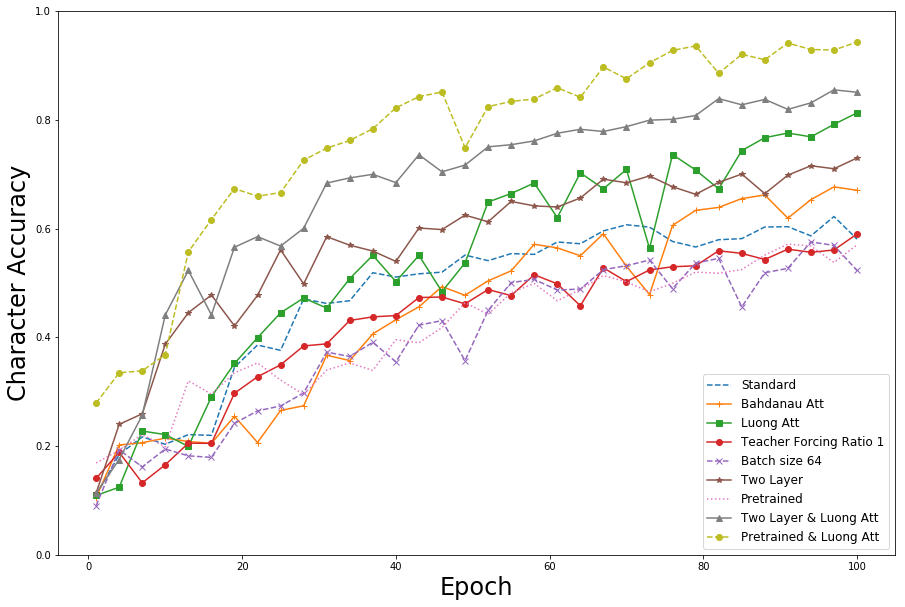

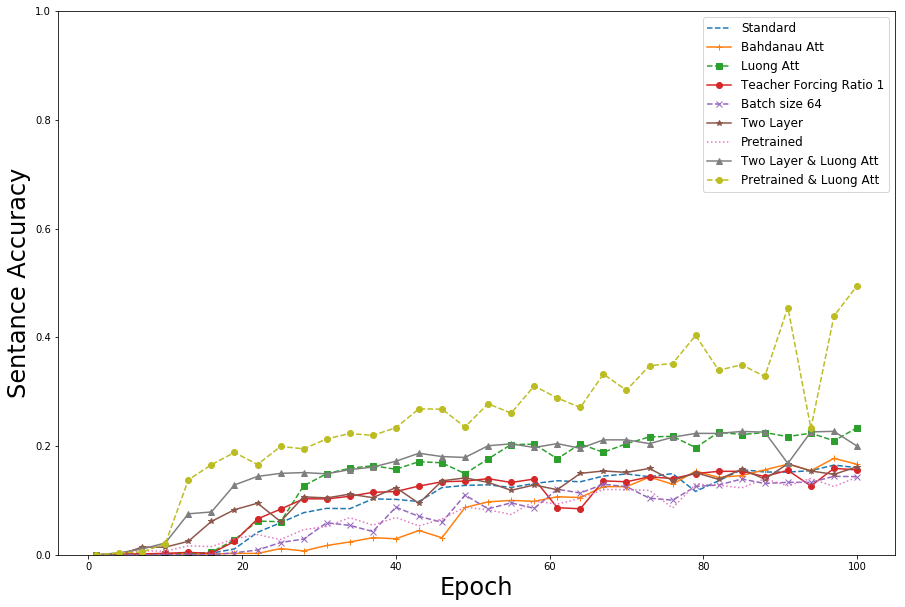

In [38]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,10))
plt.plot(epochs[::3], standard_character_accuracy_list[::3], '--', label="Standard")
plt.plot(epochs[::3], bahdanau_att_character_accuracy_list[::3], '-+', label="Bahdanau Att")
plt.plot(epochs[::3], luong_att_character_accuracy_list[::3], '-s', label="Luong Att")
plt.plot(epochs[::3], tfr_character_accuracy_list[::3], '-o', label="Teacher Forcing Ratio 1")
plt.plot(epochs[::3], batch_size_64_character_accuracy_list[::3], '--x', label="Batch size 64")
plt.plot(epochs[::3], two_layer_character_accuracy_list[::3], '-*', label="Two Layer")
plt.plot(epochs[::3], pretrained_character_accuracy_list[::3], ':', label="Pretrained")
plt.plot(epochs[::3], two_layer_Luong_att_character_accuracy_list[::3], '-^', label="Two Layer & Luong Att")
plt.plot(epochs[::3], pretrained_Luong_att_character_accuracy_list[::3], '--o', label="Pretrained & Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.savefig('log/plot/parameter_to_accuracy/bracket_epoch_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], standard_sentance_accuracy_list[::3], '--', label="Standard")
plt.plot(epochs[::3], bahdanau_att_sentance_accuracy_list[::3], '-+', label="Bahdanau Att")
plt.plot(epochs[::3], luong_att_sentance_accuracy_list[::3], '--s', label="Luong Att")
plt.plot(epochs[::3], tfr_sentance_accuracy_list[::3], '-o', label="Teacher Forcing Ratio 1")
plt.plot(epochs[::3], batch_size_64_sentance_accuracy_list[::3], '--x', label="Batch size 64")
plt.plot(epochs[::3], two_layer_sentance_accuracy_list[::3], '-*',label="Two Layer")
plt.plot(epochs[::3], pretrained_sentance_accuracy_list[::3], ':', label="Pretrained")
plt.plot(epochs[::3], two_layer_Luong_att_sentance_accuracy_list[::3], '-^', label="Two Layer & Luong Att")
plt.plot(epochs[::3], pretrained_Luong_att_sentance_accuracy_list[::3], '--o', label="Pretrained & Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentance Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.savefig('log/plot/parameter_to_accuracy/bracket_epoch_to_sentance_accuracy.png')

In [39]:
print(standard_character_accuracy_list)
print(bahdanau_att_character_accuracy_list)
print(luong_att_character_accuracy_list)
print(tfr_character_accuracy_list)
print(batch_size_64_character_accuracy_list)
print(two_layer_character_accuracy_list)
print(pretrained_character_accuracy_list)
print(two_layer_Luong_att_character_accuracy_list)
print(pretrained_Luong_att_character_accuracy_list)

[0.1092214391083429, 0.1308801835764629, 0.1841730863792821, 0.18442222586461235, 0.20031798065890838, 0.19902966726766103, 0.2169021471889854, 0.19966890673660057, 0.225382724143583, 0.2033338796918538, 0.2230290116374365, 0.23692181609572202, 0.22107195541714472, 0.24253073266677594, 0.21791181773479756, 0.2197738075725291, 0.2579118177347976, 0.29638747746271105, 0.34487788887067694, 0.3070316341583347, 0.37926897229962303, 0.38588428126536634, 0.42020324536961157, 0.40663169972135715, 0.37610883461727584, 0.46439272250450747, 0.4685100803147025, 0.47072283232257006, 0.45106703819046057, 0.47248319947549583, 0.4624487788887068, 0.5021209637764301, 0.48188821504671364, 0.4674053433863301, 0.4881462055400754, 0.5018259301753811, 0.5188985412227504, 0.5016292411080151, 0.4943615800688412, 0.5109785281101459, 0.5179577118505163, 0.5385903950172103, 0.5169119816423537, 0.5408752663497787, 0.5421570234387806, 0.5199672184887724, 0.5085559744304212, 0.5124963120799869, 0.5513784625471234, 

In [40]:
print(standard_sentance_accuracy_list)
print(bahdanau_att_sentance_accuracy_list)
print(luong_att_sentance_accuracy_list)
print(tfr_sentance_accuracy_list)
print(batch_size_64_sentance_accuracy_list)
print(two_layer_sentance_accuracy_list)
print(pretrained_sentance_accuracy_list)
print(two_layer_Luong_att_sentance_accuracy_list)
print(pretrained_Luong_att_sentance_accuracy_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0018804847471792729, 0.001671541997492687, 0.0, 0.0025073129962390303, 0.0027162557459256163, 0.007521938988717091, 0.0037609694943585457, 0.0029251984956122023, 0.011491851232762224, 0.005223568742164647, 0.010865022983702465, 0.0035520267446719597, 0.025908900961136648, 0.041370664437944, 0.041788549937317176, 0.0547430004178855, 0.058921855411617215, 0.059966569160050144, 0.057668198913497705, 0.07751776013372336, 0.07563727538654409, 0.08002507312996239, 0.08545758462181362, 0.09423318010865023, 0.09778520685332219, 0.08483075637275386, 0.09339740910990389, 0.10823234433765148, 0.10279983284580026, 0.11366485582950271, 0.10300877559548684, 0.10196406184705391, 0.11408274132887589, 0.10927705808608441, 0.09799414960300877, 0.11763476807354785, 0.11638111157542834, 0.12369410781445885, 0.10906811533639783, 0.12139573756790639, 0.12766402005850397, 0.10739657333890514, 0.12348516506477225, 0.1287087338069369, 0.11115754283326369, 0.1330965315